# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def calibrate_camera():
    
    files = glob.glob('camera_cal/calibration*.jpg')
    checkerboardsize = (9,6)
    
    h_count,v_count = checkerboardsize
    
    objp = np.zeros((v_count*h_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:h_count, 0:v_count].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    for idx, fname in enumerate(files):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (h_count,v_count), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    image = cv2.imread(files[0])
    image_size = (image.shape[1], image.shape[0])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)

    return mtx, dist

cameraMatrix, distortionCoefficients = calibrate_camera()

def undistort(image):
  
    dst = cv2.undistort(
        image, 
        cameraMatrix, 
        distortionCoefficients, 
        None, 
        cameraMatrix)
    
    return dst


def test_undistort(file):
    
    img = cv2.imread(file)
    dst = undistort(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    

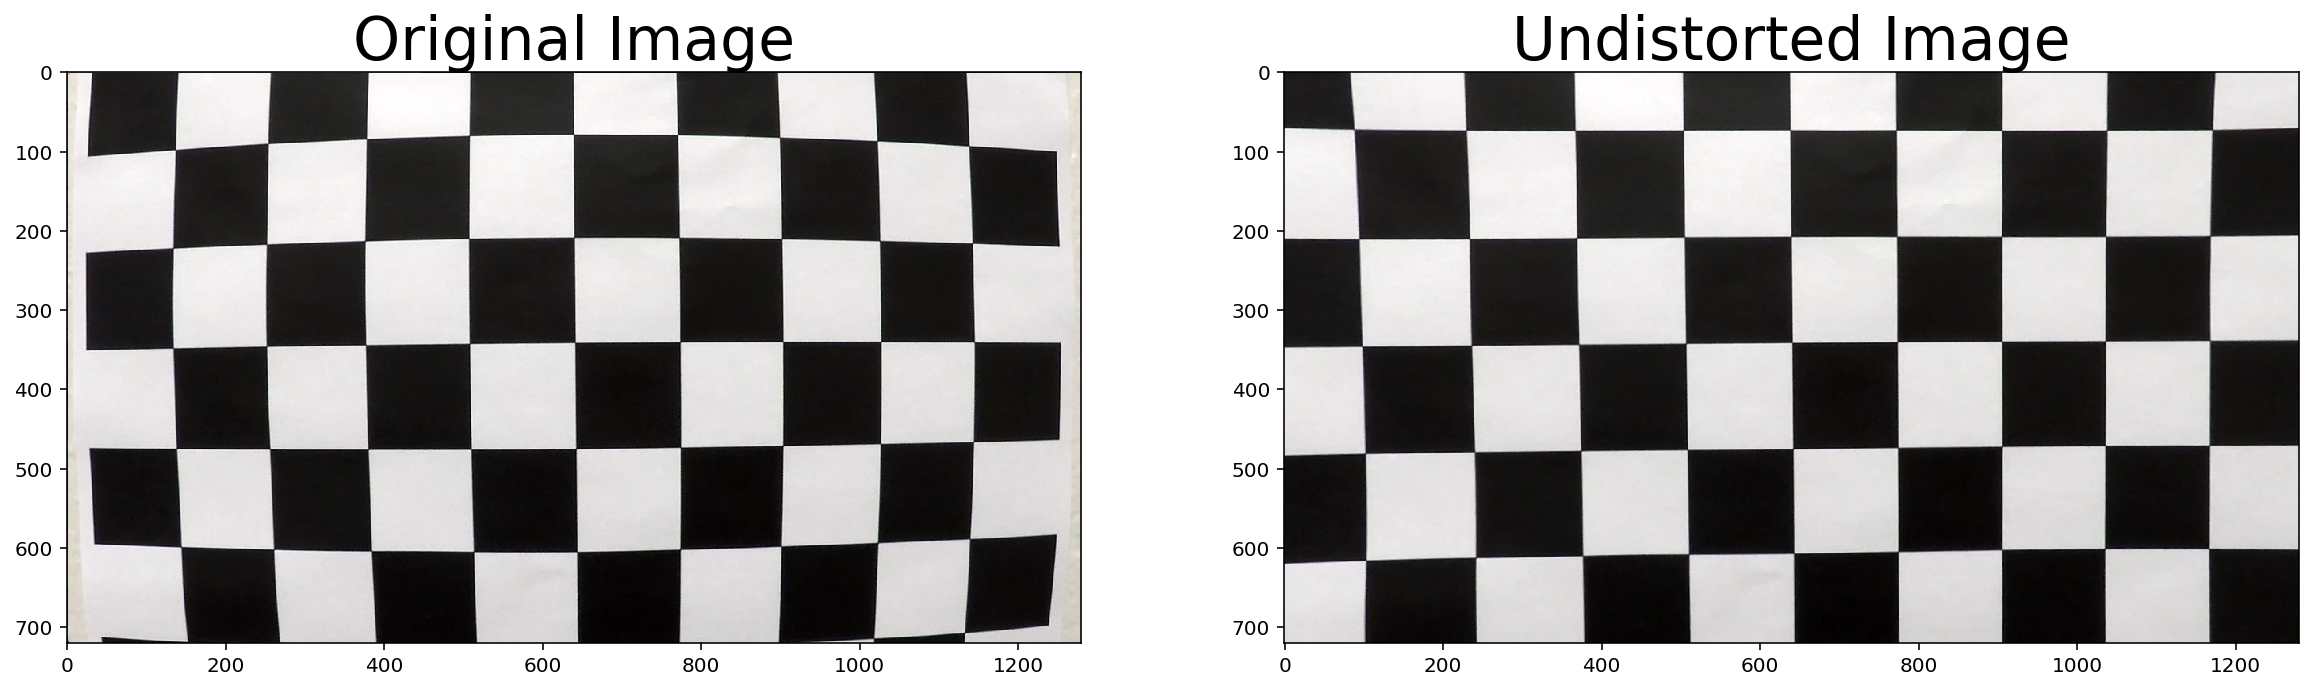

In [2]:
test_undistort('camera_cal/calibration1.jpg')

# Perspective Transform

In [3]:
def perspective_transforms():
    
    src = np.float32([
        [592,450], #top_left
        [686,450], #top_right
        [1074,693], #bottom_right
        [231,693] #bottom_left
        ])

    dst = np.float32([
        [250,0], #top_left
        [1080,0], #top_right
        [1080,720], #bottom_right
        [250,720] #bottom_left
        ])  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

TransformMatrix,InverseTransformMatrix = perspective_transforms()

def transform(image):
    result = cv2.warpPerspective(image, TransformMatrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    return result

def reverse(image):
    result = cv2.warpPerspective(image, InverseTransformMatrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    return result


def test_transform(file):
    
    img = cv2.imread(file)
  
    img = undistort(img)
    
    warped = transform(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=30) 
    plt.imshow(warped)
    

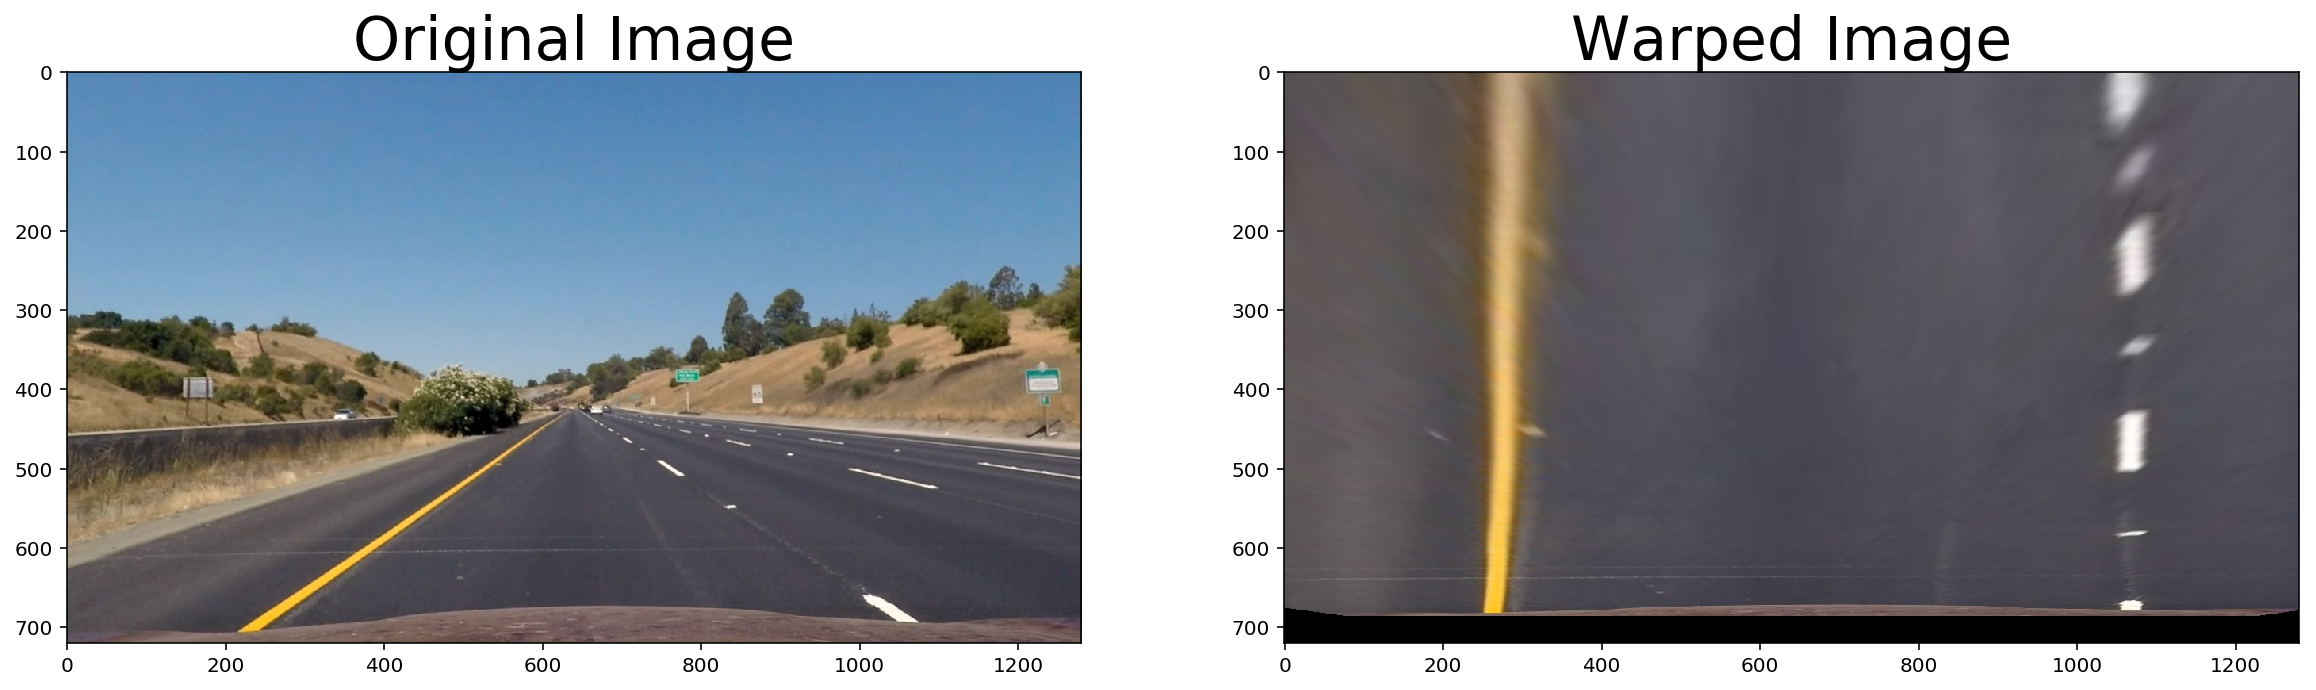

In [4]:
test_transform('test_images/straight_lines1.jpg')   

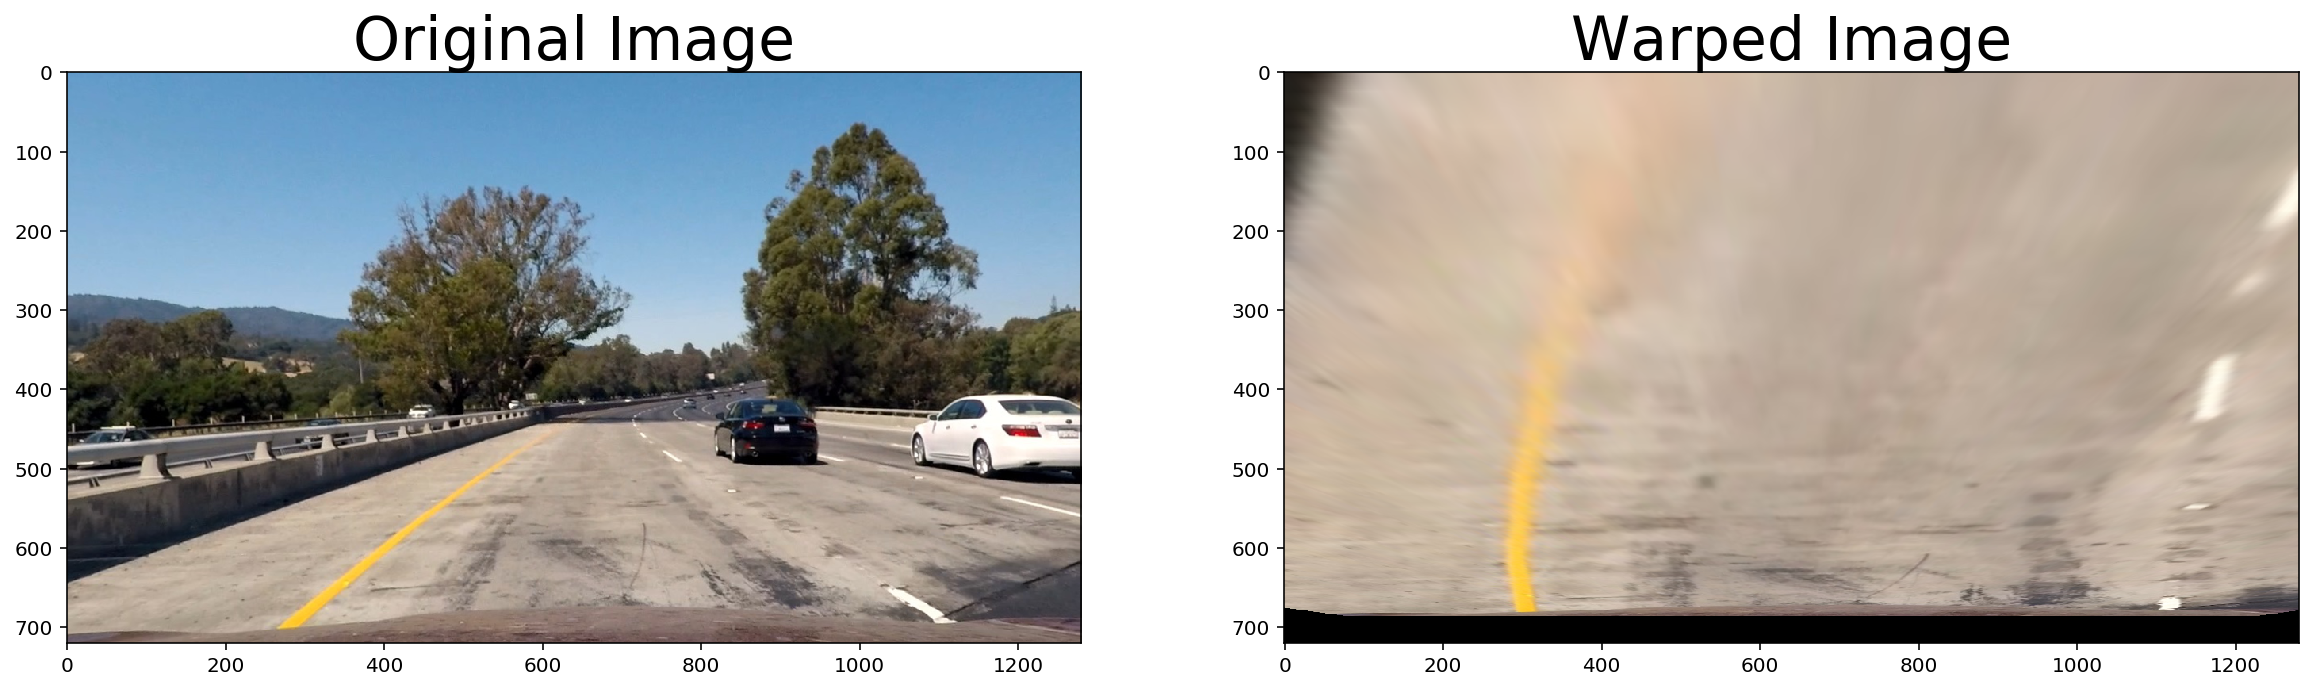

In [5]:
test_transform('test_images/test1.jpg')   

# Gradient and Color Masks

In [6]:
def gradient_axis_mask(img, axis='x', sobel_kernel=3, thresh=(0, 255)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    dx = 1 if axis == 'x' else 0
    dy = 1 if axis == 'y' else 0
    
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
 
    return grad_binary

def gradient_magnitude_mask(img, sobel_kernel=3, thresh=(0, 255)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.sqrt((sobelx)**2 + (sobely)**2)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return mag_binary


def gradient_direction_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 

    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh_min) & (direction <= thresh_max)] = 1

    return dir_binary

def hls_mask(img,component='S', thresh=(0,180)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]

    if component == 'H':
        C = H
    elif component == 'L':
        C = L
    else:
        C = S

    binary = np.zeros_like(C)
    binary[(C >= thresh[0]) & (C <= thresh[1])] = 1
    
    return binary


def mask_conjunction(mask1,mask2):
    
    binary = np.zeros_like(mask1)
    binary[(mask1 == 1) & (mask2 == 1)] = 1
    
    return binary

def mask_disjunction(mask1,mask2):
    
    binary = np.zeros_like(mask1)
    binary[(mask1 == 1) | (mask2 == 1)] = 1
    
    return binary
    

In [7]:
def create_mask(image):
       
    yellow_hue_mask = hls_mask(image, component='H', thresh=(27 * 180 / 255, 34 * 180 / 255)) #yellow hue mask
    saturation_mask = hls_mask(image, component='S', thresh=(190, 255)) #saturation mask
    #white_hue_mask = hls_mask(image, component='H', thresh=(15 * 180 / 255, 16 * 180 / 255)) #white hue mask
    
    direction_mask = gradient_direction_mask(image, thresh=(0, np.pi / 10)) #vertical gradient
    magnitude_mask = gradient_magnitude_mask(image, thresh=(10, 100)) #magnitude gradient
    result = mask_conjunction(direction_mask,magnitude_mask)  
    result = mask_disjunction(saturation_mask,result)
    #result = mask_disjunction(yellow_hue_mask,result)
    
    return result

def test_mask(file):
    
    img = cv2.imread(file)
    img = undistort(img)  
   
    mask = create_mask(img)
    mask = transform(mask)   
    #mask = reverse(mask)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(255 * mask, cmap='gray', vmin = 0, vmax = 255)
    ax2.set_title('Mask Image', fontsize=30) 

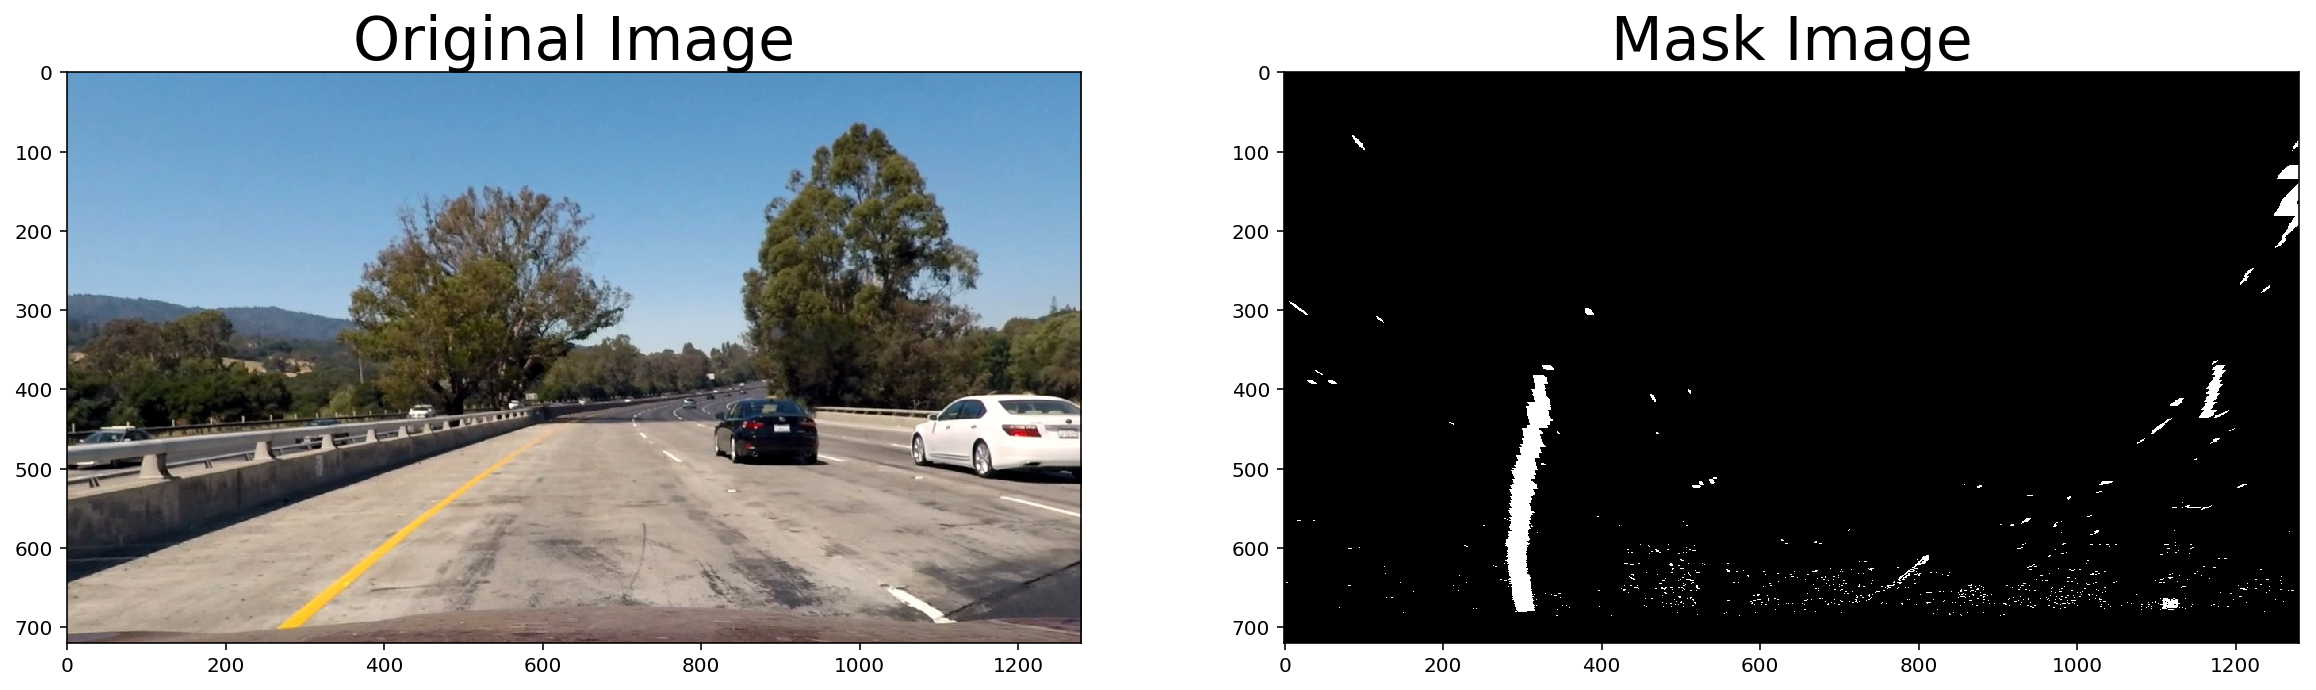

In [8]:
test_mask('test_images/test1.jpg')

In [9]:
def polynomial(fit):
    return lambda y : fit[0]*(y**2) + fit[1]*y + fit[2] 

def curvature(fit):
    return lambda y : ((1 + (2 * fit[0] * y + fit[1])**2)**1.5)/ np.absolute(2 * fit[0])

def calculate_curvature(y,x):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    fit = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    result = curvature(fit)(np.max(y))
    return result

In [10]:
def sliding_windows_fit(
    mask, 
    margin=100, # Set the width of the windows +/- margin  
    minpix=50, # Set minimum number of pixels found to recenter window
    nwindows=9 # Choose the number of sliding windows
    ):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
     
    histogram = np.sum(mask[int(mask.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((mask, mask, mask))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    

    # Set height of windows
    window_height = np.int(mask.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = mask.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin

    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = mask.shape[0] - (window+1)*window_height
        win_y_high = mask.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curvature = calculate_curvature(lefty, leftx)
    right_curvature = calculate_curvature(righty, rightx)
           
    return left_fit, right_fit, left_curvature, right_curvature, out_img 

In [11]:
def test_sliding_windows_fit(file):
    
    img = cv2.imread(file)
    img = undistort(img)  

    
    binary_warped = create_mask(img)
    binary_warped = transform(binary_warped)       
 
    left_fit, right_fit, left_curvature, right_curvature, out_img  = sliding_windows_fit(
        binary_warped, 
        minpix = 12, 
        margin = 50,
        nwindows=36)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_curve = polynomial(left_fit)
    right_curve = polynomial(right_fit)
    
    left_fitx = left_curve(ploty)
    right_fitx = right_curve(ploty)
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    ax1.imshow(out_img)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(720, 0)
    ax1.set_title('Sliding Windows', fontsize=30)
    
    ax2.imshow(255 * binary_warped, cmap='gray', vmin = 0, vmax = 255)
    ax2.set_title('Original', fontsize=30) 
    

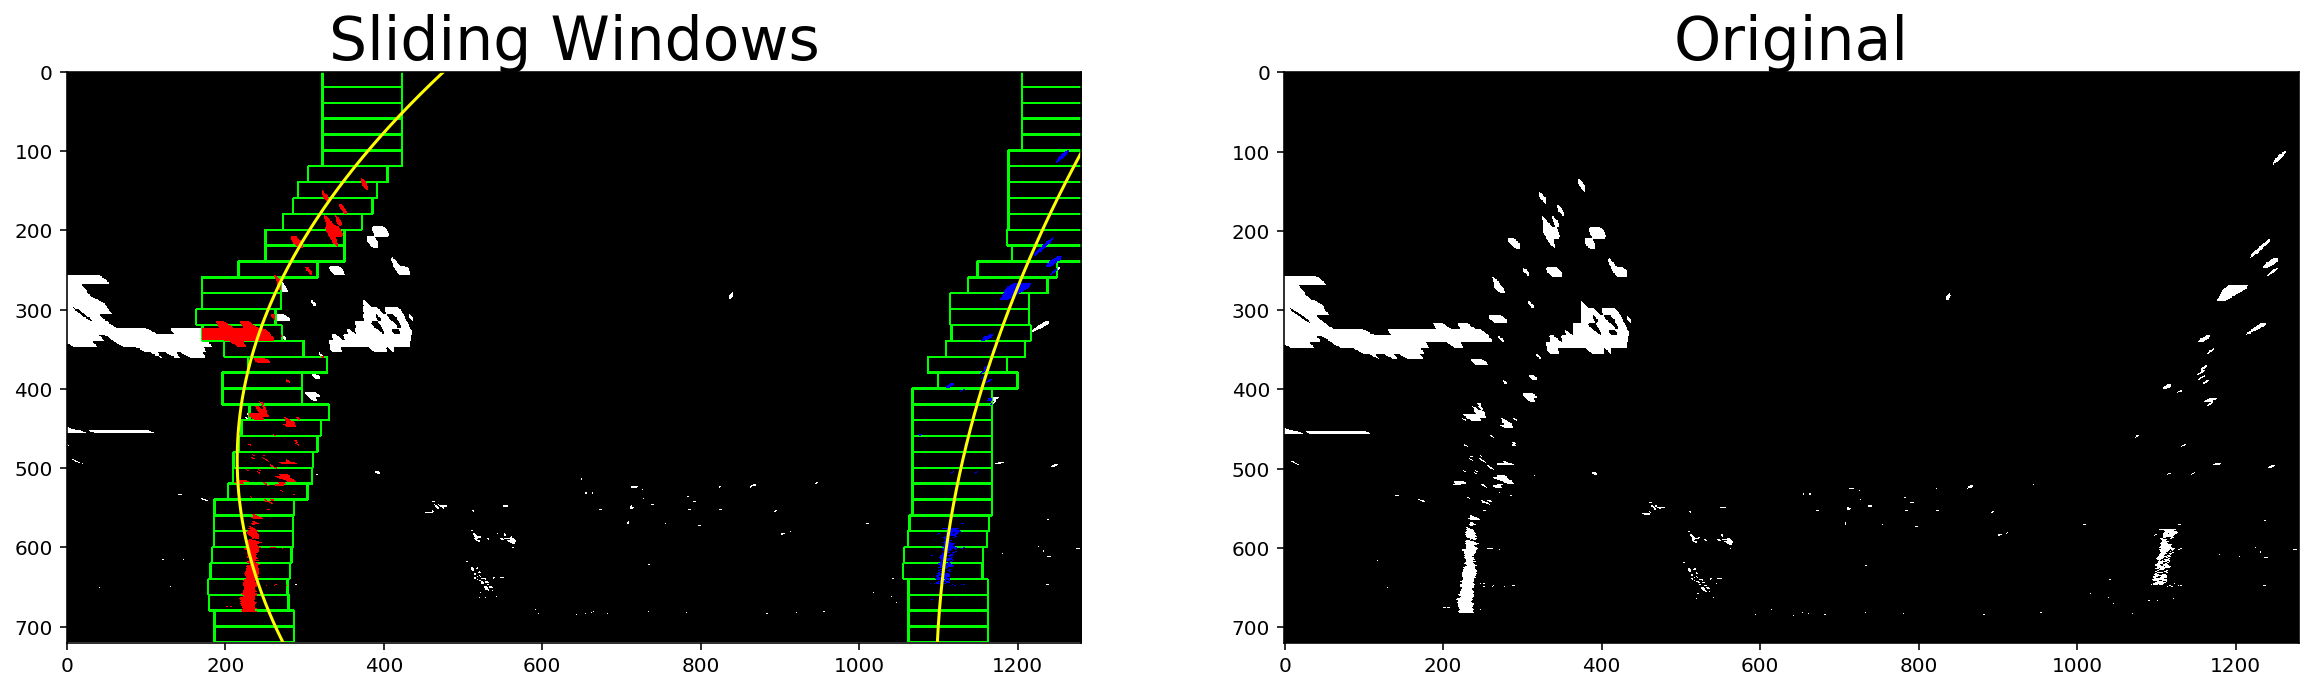

In [12]:
test_sliding_windows_fit('test_images/test5.jpg')

In [13]:
def fit(mask, left_fit, right_fit, margin=100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = mask.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_curve = polynomial(left_fit)
    right_curve = polynomial(right_fit)

    left_lane_inds = (nonzerox > left_curve(nonzeroy) - margin) & (nonzerox < left_curve(nonzeroy) + margin)
    right_lane_inds = (nonzerox > right_curve(nonzeroy) - margin) & (nonzerox < right_curve(nonzeroy) + margin)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curvature = calculate_curvature(lefty, leftx)
    right_curvature = calculate_curvature(righty, rightx)

    return left_fit, right_fit, left_curvature, right_curvature

In [14]:
def fill(img, y, x_left, x_right, color=(0,255, 0)):
    
    line_window1 = np.array([np.transpose(np.vstack([x_left, y]))])
    
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([x_right,y])))])
    
    line_pts = np.hstack((line_window1, line_window2))
    
    cv2.fillPoly(img, np.int_([line_pts]), (0,255, 0))
    
def line(img, y, x, color=(255,255,0)):
    
    pts = np.array([np.transpose(np.vstack([x,y]))])
    pts = pts.reshape((-1,1,2)).astype(int)
    cv2.polylines(img,[pts],False,color = color, thickness=3)

In [15]:
def display_curvature(img, left_curvature, right_curvature):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (20,50)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(
        img,
        "Curvature Left = {0} , Curvature Right = {1}".format(
            left_curvature//1,
            right_curvature//1), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

In [16]:
def test_fit(file):
    
    img = cv2.imread(file)
    img = undistort(img)  
    
    mask = create_mask(img)
    mask = transform(mask)
    
    margin = 50
    
    left_fit, right_fit, _, _, _ = sliding_windows_fit(
        mask,
        minpix = 12, 
        margin = margin,
        nwindows=36)

    
    left_fit, right_fit, left_curvature, right_curvature = fit(
        mask, 
        left_fit, 
        right_fit,
        margin = margin)
            
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0] )
    
    left_curve = polynomial(left_fit)
    right_curve = polynomial(right_fit)
    
    left_fitx = left_curve(ploty)
    right_fitx = right_curve(ploty)
    
    out_img = np.dstack((mask, mask, mask))*255
        
    window_img = np.zeros_like(out_img) 
            
    fill(window_img, ploty, left_fitx - margin, left_fitx + margin, color=(0,255, 0))
    fill(window_img, ploty, right_fitx - margin, right_fitx + margin, color=(0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    line(result,ploty,left_fitx)
    line(result,ploty,right_fitx)
    
    display_curvature(result,left_curvature,right_curvature)
    
    plt.imshow(result)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

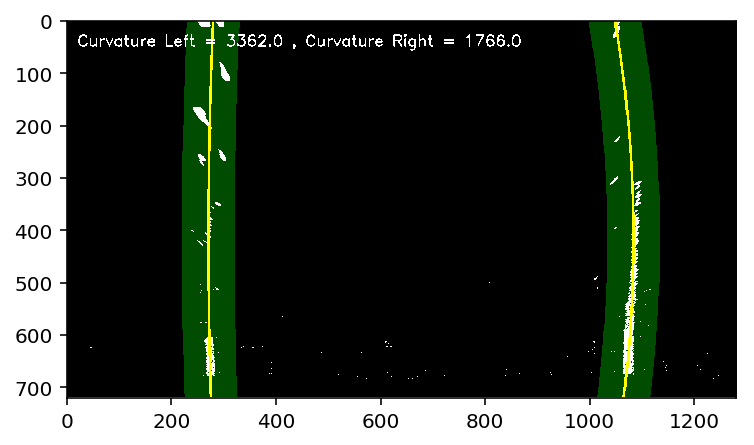

In [17]:
test_fit('test_images/straight_lines2.jpg')

In [18]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.left_fit_values = []
        self.right_fit_values = []
        
def tile(element,m):
    return np.tile(element,(m,1))

def roll(array,element):
    result = np.roll(array,1,axis=0)
    result[0] = element
    return result
        
def create_image_overlay(
    img, 
    left_fit, 
    right_fit, 
    left_curvature, 
    right_curvature):
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    left_curve = polynomial(left_fit)
    right_curve = polynomial(right_fit)
    
    left_fitx = left_curve(ploty)
    right_fitx = right_curve(ploty)

    overlay_img = np.zeros_like(img)
    
    fill(overlay_img, ploty, left_fitx, right_fitx, color=(0,255, 0))
    
    overlay_img = reverse(overlay_img)
    
    result = cv2.addWeighted(img, 1, overlay_img, 0.3, 0)
    
    display_curvature(result,left_curvature,right_curvature)

    result =  cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    return result;

def process_image(img,line):
  
    n = 5

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = undistort(img)  
    
    mask = create_mask(img)
    mask = transform(mask)
    
    margin = 50
    
    if line.detected == False:

        left_fit, right_fit, _, _, _ = sliding_windows_fit(
            mask,
            minpix = 12, 
            margin = margin,
            nwindows=36)
        
        line.left_fit_values  = tile(left_fit,n)
        line.right_fit_values = tile(right_fit,n)
        
        line.detected = True
    
    left_fit = np.mean(line.left_fit_values, axis=0) 
    right_fit = np.mean(line.right_fit_values, axis=0) 
    
    left_fit, right_fit, left_curvature, right_curvature = fit(
        mask, 
        left_fit, 
        right_fit,
        margin = 20)
    
    line.left_fit_values = roll(line.left_fit_values,left_fit)
    line.right_fit_values = roll(line.right_fit_values,right_fit)
    
    left_fit = np.mean(line.left_fit_values, axis=0) 
    right_fit = np.mean(line.right_fit_values, axis=0) 
    
    result = create_image_overlay(
        img, 
        left_fit, 
        right_fit, 
        left_curvature, 
        right_curvature)
           
    return result


def create_process_image():
    
    line = Line()
    
    return lambda img : process_image(img,line)

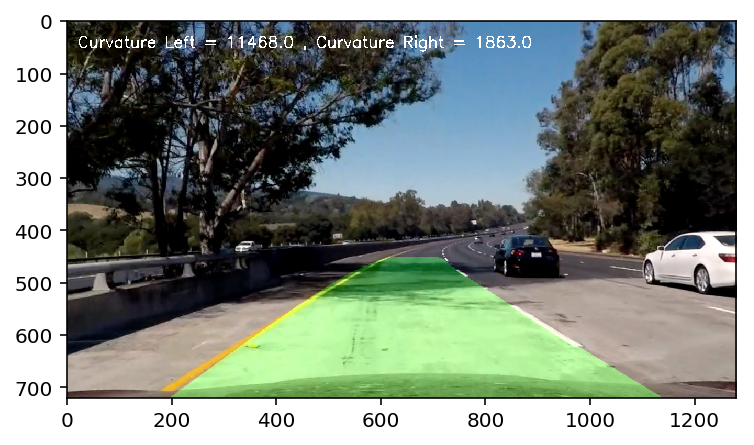

In [24]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

process = create_process_image()
result = process(img)
result = process(img)
result = process(img)
plt.imshow(result)

In [21]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
file = 'project_video.mp4'
white_output = 'output_videos/' + file

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(file)

process = create_process_image()

white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:46<00:00,  7.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 2min 46s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))